# Loading Images Using tf.Data.Dataset

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import requests
from zipfile import ZipFile
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.2.0


## Download the Data

In [11]:
### LINKS TO  DOWNLOAD DATA SETS ###
DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

### CHECK IF Datasets DIR EXISTS, IF NOT IT CREATES IT ###
if os.path.isdir('./Datasets') == False:
    os.mkdir("Datasets")

### PATH TO STore DATA SETS ###
path =  os.getcwd()           # Current (initial) path 
os.chdir(path + "\\Datasets") # Change path to Datasets
### DOWNLOAD DATASET ###
Data_set = tf.keras.utils.get_file(fname='flower_photos',origin=DATA_URL,untar=True)

os.chdir(path)                    # Go back to init      '
data_dir = pathlib.Path(Data_set) # Use pathlib to get path 
data_dir 

WindowsPath('C:/Users/Eduardo/.keras/datasets/flower_photos')

### GET TO KNOW THE DATA ###

In [34]:
### GET NUMBER OF PHOTOS ###
image_count = len(list(data_dir.glob('*/*.jpg'))) # Get list of all photos
print(f"Number of Images: {image_count}")

### Get Classes (by looking at folder dirs) ###
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(f"Class Names: {CLASS_NAMES}")




Number of Images: 3670
Class Names: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Each directory contains images of that type of flower. Here are some roses:

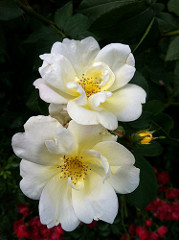

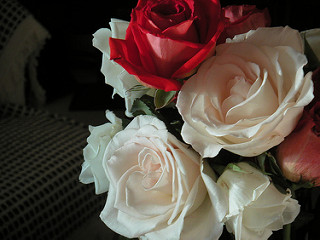

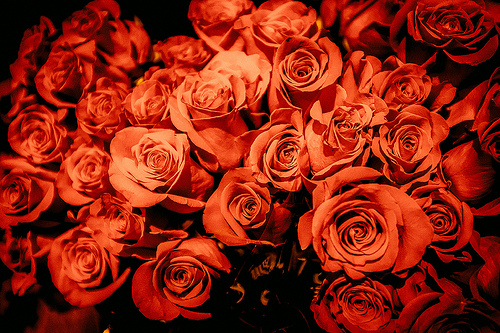

In [35]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

##  A) Load using keras.preprocessing

A simple way to load images is to use tf.keras.preprocessing.

In [26]:
### The 1./255 is to convert from uint8 to float32 in range [0,1] ###
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

### Define some parameters for the loader ###
BATCH_SIZE = 32        # 32 phtos per batch
IMG_HEIGHT = 224       # Lets make all photos 224px in Hight 
IMG_WIDTH =  224       # Lets make all photos 224px in Width 
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

### CREATE A TRAINABLE DATASET ###
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

print(f"Type: {type(train_data_gen)}")

Found 3670 images belonging to 5 classes.
Type: <class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>


Inspect a batch:

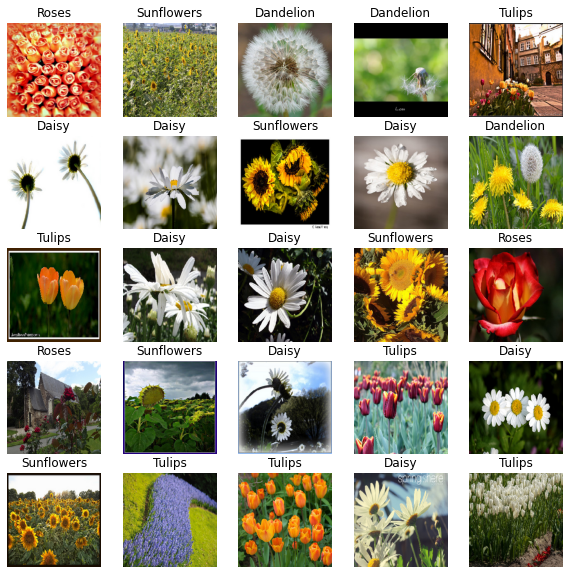

In [33]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1) 
        plt.imshow(image_batch[n]) 
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
        
### Try it out ###
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## B) Load using tf.data

The above keras.preprocessing method is convienient, but has three downsides:

* It's slow. See the performance section below.
* It lacks fine-grained control.
* It is not well integrated with the rest of TensorFlow.

To load the files as a tf.data.Dataset first create a dataset of the file paths:

In [36]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\Eduardo\\.keras\\datasets\\flower_photos\\tulips\\8681825637_837a63513a_n.jpg'
b'C:\\Users\\Eduardo\\.keras\\datasets\\flower_photos\\daisy\\2621723097_736febb4a4_n.jpg'
b'C:\\Users\\Eduardo\\.keras\\datasets\\flower_photos\\daisy\\510844526_858b8fe4db.jpg'
b'C:\\Users\\Eduardo\\.keras\\datasets\\flower_photos\\dandelion\\9853885425_4a82356f1d_m.jpg'
b'C:\\Users\\Eduardo\\.keras\\datasets\\flower_photos\\roses\\3621011057_0d03bd171b_n.jpg'


Write a short pure-tensorflow function that converts a file path to an (img, label) pair:

In [38]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep) 
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES 

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3) 
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32) 
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path) 
    img = decode_img(img)
    return img, label

Use Dataset.map to create a dataset of image, label pairs:

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False  True False]


**Next Steps: Basic methods for training**
To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the tf.data api.

In [43]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size) # TODO 3a

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

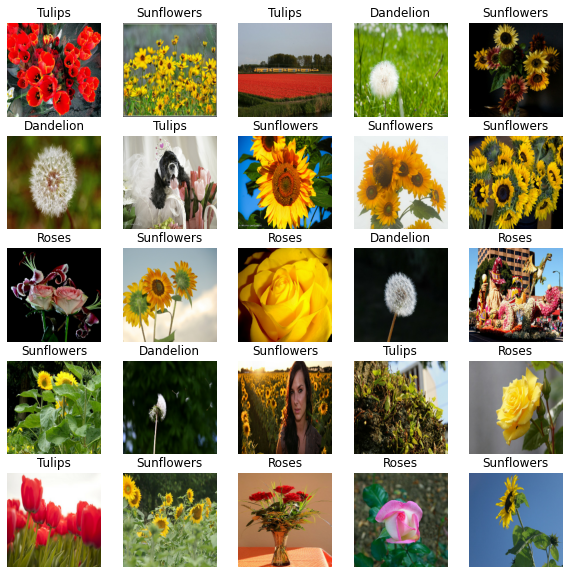

In [45]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())